In [1]:
from header import*
#import seaborn as sns

plt.rcParams.update({'font.size': 14})

In [67]:
def astar_vs_dijkstra_img(df, x, y, hline, prefix, algo1=None, algo2=None, show_mean=False, trend_line=True):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F0F0F0')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    # spines
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['algo', x], group_keys=False)[y].mean()
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='algo', values='mean_{}'.format(y))

    if trend_line:
        z = {}
        for algo in d.columns:
            s = d[algo].dropna()
            z[algo] = np.polyfit(s.index, np.log(s), 1)
            #display(s, z[algo])
        xs = list(d.index)
        if show_mean:
            d = d.append(df.groupby('algo')[y].mean().rename('all'))
        #xs.append(xs[-1]*1.1)  # extrapolation
        
        # ln(y[i]) ~= a*x[i] + b
        #  => y[i] ~= exp(a*x[i] + b)
        # y[i] = O(base^i) = C * base^i
        #  => a*x[i] + b = ln(C * base^x[i]) = ln(base)*x[i] + ln(C)
        #  => a*x[0] + b = ln(base)*x[0] + ln(C)
        #     a*x[1] + b = ln(base)*x[1] + ln(C)
        #  => a*(x[1]-x[0]) = ln(base)*(x[1]-x[0]) => base = exp(a)
        
        # Best fit lines
        for algo in d.columns:
            regression_line = []
            a, b = z[algo]
            #angle = math.atan2(a, abs(b)) * 180 / math.pi
            for i in xs:
                regression_line.append(np.exp(a*i+b))
            #display(regression_line)
            ax.plot(xs, regression_line, linestyle='-', color=algo2color(algo))
            label = '$y \sim {{{:0.3f}}}^x$'.format(np.exp(a*(s.index[1]-s.index[0])))
            ax.text(xs[-1], regression_line[-1], label, #rotation=angle,
                    color=algo2color(algo), ha='center', va='bottom', size=16, alpha=1)
    
    # ticks
    if x == 'error_rate':
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=1))
    
    if x == 'cost':
        ax.set_xticks(np.arange(0, max(df[x])+1, 1))
    arr = [ 0 ] + [ 10**n for n in range(0,int(math.log10(max(df[y])))+1) ]
    ax.set_yticks(arr)

    # Times
    #for index, row in d.iterrows():
        #print(row["astar-seeds"])
        #print(row["astar-seeds-intervals"])
    #    label = '{0:.3g}x'.format(row[algo1] / row[algo2])
    #    tmp_x = index if index != 'all' else len(d)-1
    #    tmp_y = np.exp((np.log(row[0]) + np.log(row[1])) / 2)
    #    ax.text(tmp_x, tmp_y, label, ha='right', va='center', size=12, alpha=0.7)
        
    colors = [ algo2color(algo) for algo in d.columns ]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot(ax=ax, alpha=0.9, zorder=3, rot=0, color=colors, marker='o', ls='')
    #d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    if hline:
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 16}, framealpha=0.5)
    else:
        ax.legend(loc="upper left", prop={'size': 16}, framealpha=0.5)

    if hline:
        if y == 'explored_states':
            miny = df.len.median()
            maxy = df.refsize.median()*df.len.median()
        elif y == 'explored_per_bp':
            miny = 1
            maxy = df.refsize.median()
        else:
            assert(False)
        
        ax.axhline(maxy, color='k', linestyle='solid', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(max(df[x])*1.1, maxy, 'Total\nstates', ha='left', va='center', size=16)
        
        ax.axhline(y=miny, color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(max(df[x])*1.1, miny, 'Lower\nbound', ha='left', va='center', size=16)

    ax.set_yscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,explored_per_bp,error_rate
0,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-prefix,align,0.0,250,TTACAGCATTACGCCAGACCTATGAAGAGGTCCTGCGACTGGCGGT...,TTAcAGCATTACGCCAGaCCTATGAAGAGGtCCTGCGACTGGCGGT...,4,680327,+,109.632,11.100,0.0,0.337200,0.136686,1,3272,120.732,13.088,0.016
1,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-prefix,align,0.0,250,CGACGGACAGCAATACTGAAAGCATCAGTCCTCCAGAAATAAGGCC...,CGACgGaCAGCAATACTGAAAGcATCAGTcCTCCaGAAATAAGGCC...,5,478551,+,535.020,48.672,0.0,1.512906,0.558837,1,14647,583.692,58.588,0.020
2,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-prefix,align,0.0,250,GCGACGAGGCAATATTGGCGGCGAATGTCCGGCGCTGGCGACCACG...,GCGACGAGGCAAtATTgGCGGCGaATGTCCGGCGCTGGCGACCACG...,3,416599,+,30.760,3.308,0.0,0.126592,0.043022,1,1088,34.068,4.352,0.012
3,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-prefix,align,0.0,250,CCTTGTCCGTATGTTCCCAATCAAGTGCTGTACCGGGATTATCGAT...,CCTTgTCCgTATGtTCCCAATCAAGTGCTGTAcCGGGATTATCGAT...,4,390152,-,73.704,7.900,0.0,0.230928,0.100349,1,2252,81.604,9.008,0.016
4,data/ecoli_head1000000_linear/graph.gfa,2298530,astar-prefix,align,0.0,250,ATCGGCACTGCTGATTTCACCATCCGTGCGTAAATAAAACCGGGTG...,ATCGGCAcTGcTGATTtCACCATcCGTGCGTAAATAAAACCGGGTG...,6,262724,+,953.388,85.104,0.0,2.445574,0.795725,1,27297,1038.492,109.188,0.024


,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,explored_per_bp,error_rate
1184,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,CTGTCAGCTACGACGCGCCACACTGTCCGCTTTGGCGGTGTACTGA...,CTGtCAGCTACGACGCGCCACACTGTCCGCTTTGGCGGTGTACTGA...,1,24388,-,6.992,0.788,0.0,0.303125,0.001783,1,452,7.780,1.808,0.004
1185,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,TGTTGTGGTTAATACCGGCTTTAGTCACTTCGTTCGACACCAGCTG...,tGTTGTGgTTAATACCGGCTTTaGTCAcTTCGTTcGACACCAGCTg...,6,109461,-,16054.756,3366.088,0.0,37.799978,2.926044,1,1072071,19420.844,4288.284,0.024
1186,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,TCTAGACCGCAAACACCAACCGATTTGTCGCATCGCTAATAACCTC...,TcTAgACcgCAAACacCAACCGATTTGTCgcaTCGCTAATAACCTC...,9,127438,-,66056.140,23698.308,0.0,202.257164,11.633938,1,7574265,89754.448,30297.060,0.036
1187,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,AGCAAATCGGACCAAATTGCAGAGAACATGACACCGAACAGCGCAA...,AgCAAATCGGACCAAATTGCagAGAACATGACACCGAACAGCGCAA...,3,488727,-,474.700,66.908,0.0,10.640962,0.074967,1,19201,541.608,76.804,0.012
1188,data/ecoli_head1000000_linear/graph.gfa,2298530,dijkstra,align,0.0,250,TGGCGCATTTTCTGTACTATAACATTACCACTGACCTTACCGGGAA...,TGGCGCaTTTTCTgTACTATaACaTTACCaCTGACCTTACCGGGAA...,5,796261,+,6679.100,1216.512,0.0,13.907798,1.115154,1,387771,7895.612,1551.084,0.020


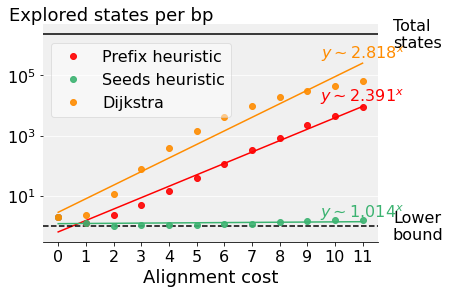

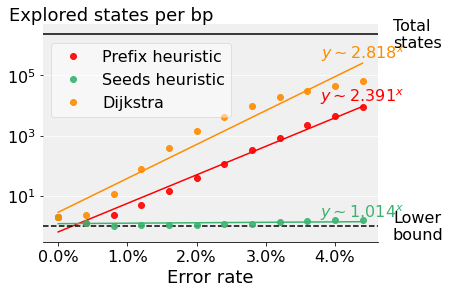

In [68]:
experiment_name = 'prefix_vs_seeds_ecoli_250_errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-prefix/alignments.tsv')
df = df.append(read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/astar-seeds/alignments.tsv'), ignore_index=True)
df = df.append(read_astarix_performance('../tmp/ecoli_head1000000_linear_eval250/dijkstra/alignments.tsv'), ignore_index=True)

display(df.head())
display(df.tail())

astar_vs_dijkstra_img(df, y='explored_per_bp', x='cost', hline=True, prefix=experiment_name)
astar_vs_dijkstra_img(df, y='explored_per_bp', x='error_rate', hline=True, prefix=experiment_name)
#astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, algo1="astar-prefix", algo2="astar-seeds")

In [24]:
experiment_name = 'MHC'
plots_dir = Path('plots')
df = read_astarix_performance('results/MHC1-astarix-prefix/alignments.tsv')
#df = df.append(read_astarix_performance('results/MHC1-astarix-seeds/alignments.tsv'), ignore_index=True)
df = df.append(read_astarix_performance('results/MHC1-astarix-seeds-bfs/alignments.tsv'), ignore_index=True)

#df = read_astarix_performance('results/ecoli_illumina250_astar-seeds.tsv')
#df = df.append(read_astarix_performance('results/ecoli_illumina250_astar-prefix.tsv'), ignore_index=True)

#df.algo = df.algo.replace(regex=r'astar.*', value='astar')
reads = len(df)
df = df[df.cost <= 8.0]

#display(df.groupby('algo').mean())
display(df.head())
#display(df.groupby('cost').size() / reads)

KeyError: 'explored_states'

In [5]:
def draw_one(df, x, y, hline, prefix, is_log=True, show_mean=True):
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 4, forward=True)
    
    # grid
    ax.set_facecolor('#F0F0F0')
    
    # ticks
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
        labelsize=16,
    )
    
    #ax.tick_params(
    #    axis='y',          # changes apply to the x-axis
    #    which='minor',      # both major and minor ticks are affected
    #    left=False,         # ticks along the top edge are off
    #    labelbottom=False # labels along the bottom edge are off
    #)
    
    # spines
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Data
    d = df.groupby(['algo', x], group_keys=False)[y].mean()
    d = d.reset_index(name='mean_{}'.format(y))
    d = d.pivot(index=x, columns='algo', values='mean_{}'.format(y))

    z = {}
    for algo in d.columns:
        s = d[algo].dropna()
        ydata = np.log(s) if is_log else s
        z[algo] = np.polyfit(s.index, ydata, 1)
        
    xs = list(d.index)
    if show_mean:
        d = d.append(df.groupby('algo')[y].mean().rename('all'))
    xs.append(xs[-1]+0.8)  # extrapolation
        
    colors = [algo2color(algo) for algo in d.columns]
    d.columns = [ algo2beautiful(col) for col in d.columns ]
    
    ########### Bars
    d.plot.bar(ax=ax, alpha=0.5, width=0.7, zorder=3, rot=0, color=colors)
    
    if hline:
        ax.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95), prop={'size': 16}, framealpha=0.5)
    else:
        ax.legend(loc="upper left", prop={'size': 16}, framealpha=0.5)
    
    if hline:
        ax.axhline(df.refsize.median()*df.len.median(), color='k', linestyle='solid', label=df.ref[0]) #, xmin=min(df[x]), xmax=max(df[x])+1
        ax.text(max(df[x])+1.7, df.refsize.median()*df.len.median(), 'Total\nstates', ha='left', va='center', size=16)
        
        ax.axhline(y=df.len.median(), color='k', linestyle='--', label=df.ref[0])  # xmin=min(df[x]), xmax=max(df[x])+1, 
        ax.text(max(df[x])+1.7, df.len.median(), 'Lower\nbound', ha='left', va='center', size=16)

    if is_log:
        ax.set_yscale('log')
       
    #ax.grid(True, which='both', axis='y', color='w')
    #ax.grid(False, axis='x', which='both')
    ax.grid(True, axis='y', which='major', color='w')
    ax.grid(False, axis='y', which='minor')
    
    # axis labels
    ax.set_xlabel(col2name(x), size=18)  # weight='bold',
    ax.set_ylabel(col2name(y), rotation=0, ha='left', size=18)
    ax.yaxis.set_label_coords(-0.10,1.00)
    
    if y == 't(map)':
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, pos: myticks(num, pos)+'s'))
    
    #plt.savefig(prefix+'_'+x+'-'+y+'.pdf', bbox_inches='tight')
    plt.savefig(plots_dir/(prefix+'_'+x+'-'+y+'.pdf'), bbox_inches='tight')

In [6]:
#def run(experiment_name, tsv_file, plots_dir):
experiment_name = 'ecoli_clr_1000_2errors_nointervals'
plots_dir = Path('plots')
df = read_astarix_performance('results/' + experiment_name + '.tsv')
print(df.head())
#df = df.append(read_astarix_performance('tmp/ecoli_head1000000_linear_long_clr/astar-default/alignments.tsv'), ignore_index=True)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name)
draw_one(df, y='t(map)', x='cost', hline=False, prefix=experiment_name)

KeyError: 'explored_states'

In [7]:
experiment_name = 'ecoli_ccs300'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_ccs_1000_0errors_intervals.tsv')
#df = df.append(read_astarix_performance('tmp/ecoli_head1000000_linear_long_clr/astar-default/alignments.tsv'), ignore_index=True)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, is_log=True)
draw_one(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, is_log=True)

KeyError: 'explored_states'

In [8]:
experiment_name = 'ecoli_ccs_1000_0errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_ccs_1000_0errors_intervals.tsv')
df = df.append(read_astarix_performance('results/ecoli_ccs_1000_0errors_nointervals.tsv'), ignore_index=True)

print(df.head())
print(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix='heuristic_'+experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals", show_mean=True)
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix='heuristic_'+experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals", show_mean=False)

KeyError: 'explored_states'

In [9]:
experiment_name = 'ecoli_clr_1000_2errors_intervals_cmp'
plots_dir = Path('plots')
df = read_astarix_performance('results/ecoli_clr_1000_2errors_intervals.tsv')
df = df.append(read_astarix_performance('results/ecoli_clr_1000_2errors_nointervals.tsv'), ignore_index=True)

print(df.head())
print(df.tail())

astar_vs_dijkstra_img(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals")
astar_vs_dijkstra_img(df, y='t(map)', x='cost', hline=False, prefix=experiment_name, algo1="astar-seeds", algo2="astar-seeds-intervals")

KeyError: 'explored_states'

In [10]:
import seaborn as sns

def plot_states_per_kb(df):
    df['lenbin'] = (df['len'] // 150) * 150
    #df['explored_per_bp'] = df['explored_states'] / df['len']
    fig, axes = plt.subplots()
    bylen = df.groupby(by='lenbin')
    display(bylen.mean())
    p = bylen['explored_per_bp'].plot(figsize=(15,5),legend=False,kind="bar",rot=45,color="blue",fontsize=16) #,yerr=bylen.std());
    #ax = sns.violinplot(x="lenbin", y="explored_per_bp", data=df)
    #ax = df[['explored_per_bp', 'lenbin']].boxplot(by='lenbin', showfliers=False)
    #ax.set_yscale('log')

In [4]:
experiment_name = 'seeds_length_scaling_ccs'
plots_dir = Path('plots')
df = read_astarix_performance('../tmp/ecoli_head1000000_linear_ccs/astar-seeds/alignments.tsv')

display(df.head())
display(df.tail())

plot_states_per_kb(df)
draw_one(df, y='explored_states', x='cost', hline=True, prefix=experiment_name, is_log=True)
draw_one(df, y='explored_states', x='len', hline=True, prefix=experiment_name, is_log=True)

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,explored_per_bp
readname,,,,,,,,,,,,,,,,,,,,
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435951,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782,2.921053
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435953,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782,2.921053
S1_1,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,266,GACAGTTTGTTTGATCTTCTCAATTATTACCGTATGCAACTCATGG...,GACAGTTTGTTTGATCTTCTCAATTATTACcgTATGCAACTCATGG...,10,435952,+,9.206767,1.906015,0.0,0.027331,0.003129,0,777,11.112782,2.921053
S1_2,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,454,AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAAT...,AAGAAACCGCCGTCGCTACGATGAAGCGCTTCCGCTGGCAGGCAAT...,8,510400,-,0.370044,0.072687,0.0,0.002926,0.000439,1,477,0.442731,1.050661
S1_3,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,493,TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTC...,TTCTGTTTGTTGCCGCCATCTGGACCTGCCAGGGATCCCAATGTTC...,10,46550,+,0.405680,0.107505,0.0,0.003784,0.000585,1,547,0.513185,1.109533


,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,explored_per_bp
readname,,,,,,,,,,,,,,,,,,,,
S1_19996,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,518,AGCGGTTGATAGCAGTTTTCAATGCACCAAATGGAGGCGGTAAACG...,AGCGGTTGATAGCaGTTTTCAaTGCACCAAATGGAGGCGGTAAACG...,19,891215,-,4.328185,0.720077,0.0,0.040183,0.006390,1,907,5.048262,1.750965
S1_19997,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,519,TACGGTACGGGTCAACTGCCGAAATTGCTGGCATCTGTTCCATACT...,TACGGTACGGGTCAACTGCCGAAATTGCTGGCATCTGTTCCATACT...,8,940050,+,1.107900,0.190751,0.0,0.017146,0.004364,1,616,1.298651,1.186898
S1_19998,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,484,ACAGCCTGGCCATCATTACGCCATTCGTGCAGGTCGGACTTACCCG...,ACAGCCTGGCCATCATTACGCCATTCGTGCAGGTCGGACTTACCCG...,12,227270,-,0.789256,0.157025,0.0,0.008962,0.001720,1,554,0.946281,1.144628
S1_19999,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,323,TTGCCGACATCCCCGAAGCCCTTGCCAACACCGTTGAGATCGCCAA...,TTGCCGACATCCCCGAAGCCCTTGCCAACACCGTTGAGATCGCCAA...,3,205879,+,0.442724,0.061920,0.0,0.005810,0.000629,1,332,0.504644,1.027864
S1_20000,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,457,ATAATATTTATTATCATCAAGTACCAGTCCCACCGAGTCTAAAAAT...,ATAATATTTATTATCATCAAGTACCAGTCCCACCGAGTCTAAAAAT...,7,872843,-,0.391685,0.076586,0.0,0.004731,0.000694,1,484,0.468271,1.059081


NameError: name 'plot_states_per_kb' is not defined

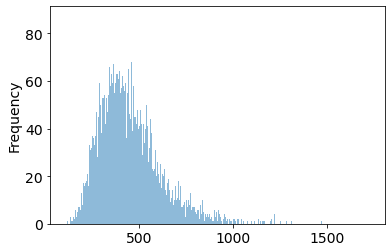

In [12]:
ax = df['len'].plot.hist(bins=max(df['len'])-min(df['len'])+1, alpha=0.5)

<AxesSubplot:xlabel='len', ylabel='explored_states'>

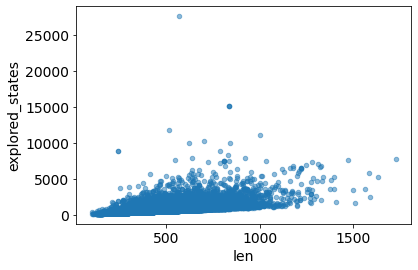

In [13]:
df.plot.scatter(x='len', y='explored_states', alpha=0.5)

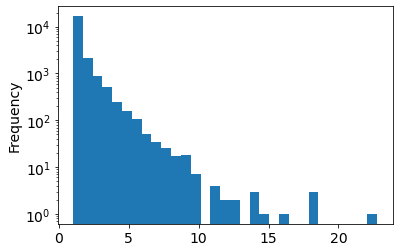

In [14]:
ax = df.loc[df['explored_per_bp'] < 30]['explored_per_bp'].plot.hist(bins=31)
ax.set_yscale('log')

In [16]:
df.loc[df['explored_per_bp'] < 1.0]

,ref,refsize,algo,operation,memory,len,read,spell,cost,start,strand,pushed,popped,repeat_rate,t(map),t(astar),unique_best,explored_states,pushed+popped,lenbin,explored_per_bp
readname,,,,,,,,,,,,,,,,,,,,,
